Epoch 1/50


C:\Users\merta\AppData\Local\Temp\ipykernel_30420\3788332745.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0376
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0015
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.7674e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.0214e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.3851e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.9880e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.8056e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.1565e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.5545e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.4837e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.3323e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.1091e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.6831e-04
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.1949e-04
Epoch 15/50
529/529 

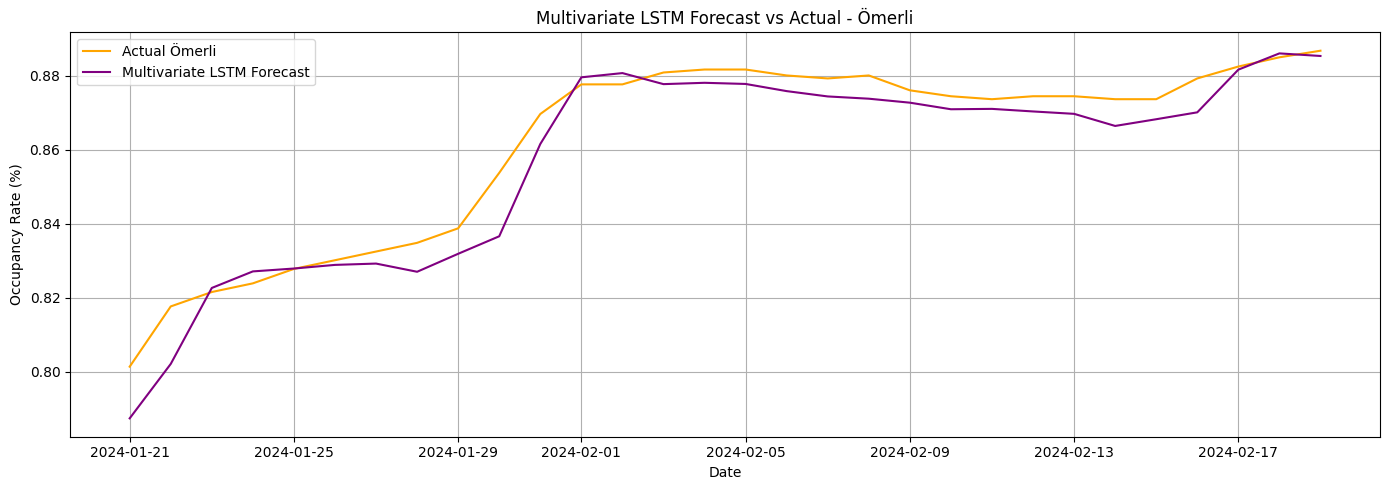

In [14]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Loading the dam-specific dataset
df = pd.read_excel("../data/raw/istanbul-dams-daily-occupancy-rates.xlsx")

# Converting the 'Tarih' column to datetime using automatic detection with dayfirst
df['Tarih'] = pd.to_datetime(df['Tarih'], dayfirst=True)
df = df.set_index('Tarih')

# Filling any missing values by forward fill method (ensuring clean dataset)
df = df.fillna(method='ffill')

# Defining look-back period
look_back = 30

# Scaling the data using MinMaxScaler (fitting across all columns)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Creating multivariate sequences
def create_multivariate_sequences(data, look_back=30):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :])
        y.append(data[i, :])  # multi-output: predicting all dams at once
    return np.array(X), np.array(y)

# Creating sequences
X, y = create_multivariate_sequences(scaled_data, look_back)

# Splitting train and test (last 30 days as test)
X_train, y_train = X[:-30], y[:-30]
X_test, y_test = X[-30:], y[-30:]

# Building the LSTM model (multi-input, multi-output)
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1]))  # output dimension = number of dams
model.compile(optimizer='adam', loss='mse')

# Training the model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Making predictions on the test set
predictions = model.predict(X_test)
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Calculating metrics (average across all dams)
mae_lstm_multi = mean_absolute_error(y_test_inverse, predictions_inverse)
rmse_lstm_multi = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))

print(f"Multivariate LSTM MAE (Test Set): {mae_lstm_multi:.2f}")
print(f"Multivariate LSTM RMSE (Test Set): {rmse_lstm_multi:.2f}")

# Plotting one example dam (e.g., Ömerli)
dam_index = df.columns.get_loc('Ömerli')
plt.figure(figsize=(14,5))
plt.plot(df.index[-30:], y_test_inverse[:, dam_index], label='Actual Ömerli', color='orange')
plt.plot(df.index[-30:], predictions_inverse[:, dam_index], label='Multivariate LSTM Forecast', color='purple')
plt.title("Multivariate LSTM Forecast vs Actual - Ömerli")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
